## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [15]:
#@title Data retrieval
import os, requests


from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
fname = './data/motor_imagery.npz'

#@title Data retrieval
import os, requests

#@title Data loading
import numpy as np
alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper: 

*Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697.*

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior. 

Both experiments: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV). 
* `dat['locs`]`: 3D electrode positions on the brain surface



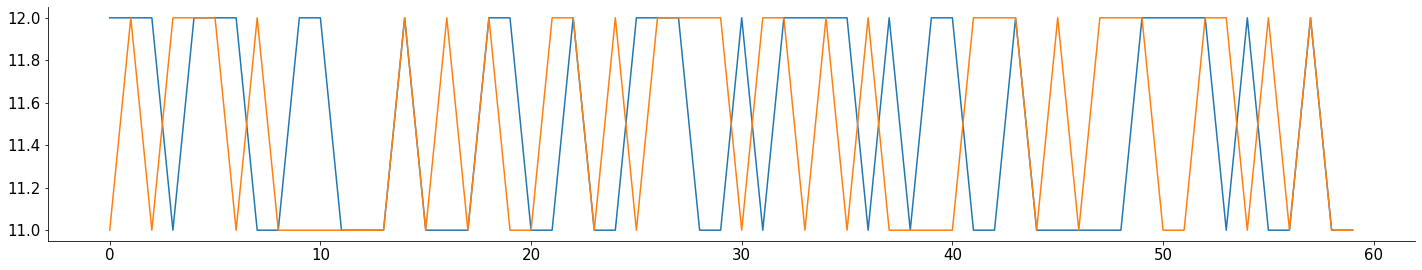

In [ ]:
plt.plot(dat1['stim_id'])
plt.plot(dat2['stim_id'])

In [16]:
from nilearn import plotting  
from nimare import utils

plt.figure(figsize=(8,8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = ['%d'%k for k in np.arange(locs.shape[0])], marker_color = 'purple', marker_size=5)
view

<Figure size 576x576 with 0 Axes>

In [93]:
# quick way to get broadband power in time-varying windows
from scipy import signal

def pre_process(data, subj, exp, hpf=None):
    # pick subject 0 and experiment 0 (real movements)
    dat1 = alldat[subj][exp]

    # V is the voltage data
    V = dat1['V'].astype('float32')
    
    if hpf:
        # high-pass filter above 50 Hz
        b, a = signal.butter(3, [hpf], btype = 'high', fs=1000) # why is it a thrid order filter?
        V = signal.filtfilt(b,a,V,0)

        # compute smooth envelope of this signal = approx power
        V = np.abs(V)**2
        b, a = signal.butter(3, [10], btype = 'low', fs=1000)
        V = signal.filtfilt(b,a,V,0)

        # normalize each channel so its mean power is 1
        V = V/V.mean(0) 
    return V

V = pre_process(data=dat1, subj=0, exp=0, hpf=50)
V_nohpf = pre_process(data=dat1, subj=0, exp=0)

In [94]:
# average the broadband power across all tongue and hand trials
def comp_avg_signal(V, length, muscle):
    nt, nchan = V.shape
    nstim = len(dat1['t_on'])
    stim_id = {'tongue':11, 'hand':12}[muscle]
    trange = np.arange(0, length) #time range?
    ts = dat1['t_on'][:,np.newaxis] + trange #time series 
    V_epochs = np.reshape(V[ts, :], (nstim, length, nchan))
    return (V_epochs[dat1['stim_id']==stim_id]).mean(0)
    
V_tongue = comp_avg_signal(V, 2000, 'tongue') # averging across the experiment no.
V_hand   = comp_avg_signal(V, 2000, 'hand')

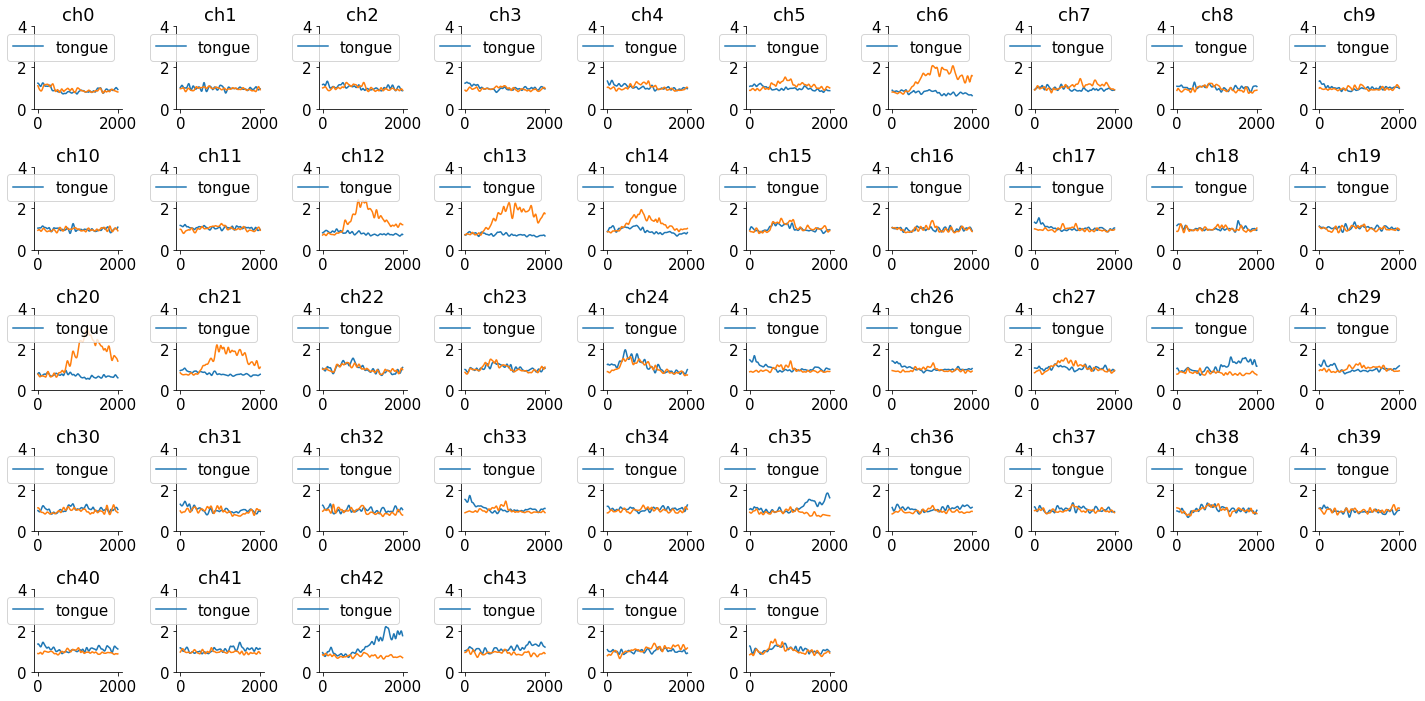

In [95]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue 
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
for j in range(46):
    ax = plt.subplot(5,10,j+1)
    plt.plot(trange, V_tongue[:,j], label= 'tongue') #blue
    plt.plot(trange, V_hand[:,j]) #orange
    plt.title('ch%d'%j)
    plt.xticks([ 0, 2000])
    plt.ylim([0, 4])
    plt.legend()
  

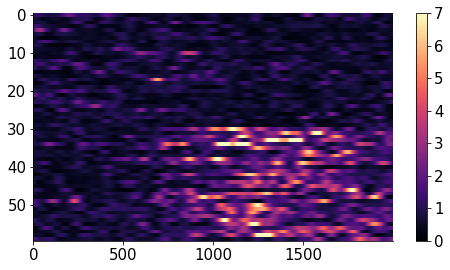

In [21]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1,3,1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort,:,20].astype('float32'), aspect='auto', vmax=7, vmin = 0, cmap = 'magma')
plt.colorbar()

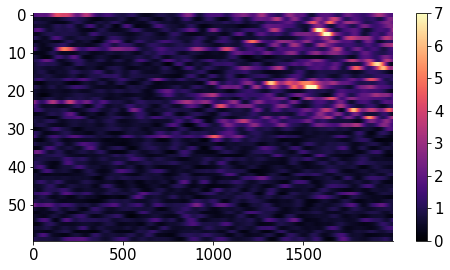

In [22]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1,3,1)
plt.imshow(V_epochs[isort,:,42].astype('float32'), aspect='auto', vmax=7, vmin = 0, cmap = 'magma')
plt.colorbar()

In [24]:
from neurodsp.spectral import compute_spectrum
from fooof import FOOOFGroup, FOOOF

```
nperseg : int, optional
        Length of each segment, in number of samples.
        If None, and window is str or tuple, is set to 1 second of data.
        If None, and window is array_like, is set to the length of the window.
noverlap : int, optional
    Number of points to overlap between segments.
    If None, noverlap = nperseg // 8.
```
        
max length is 9960??

Comparison plots 
- what are the differences and what are the right features
- How do they vary
- Make list of things we want to compare (spectral features)
- Compare classifier performances based on what you see in the plots

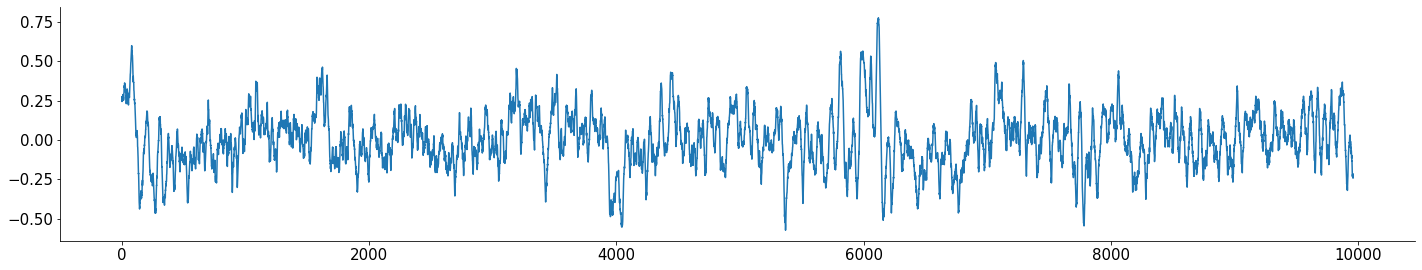

In [108]:
kwargs = {'fs':1000, 'nperseg':None, 'noverlap':None}
sample = comp_avg_signal(V_nohpf, 9960, 'hand')
chan = 12
plt.plot(sample[:,chan])
freqs, powers = compute_spectrum(sample[:,chan], **kwargs)

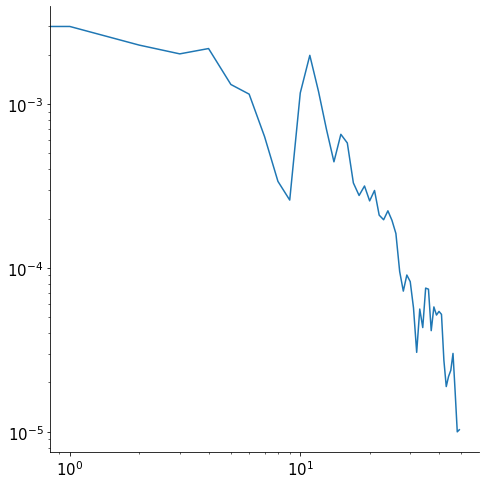

In [109]:
plt.figure(figsize=(7,7))
plt.loglog(freqs[:50],powers[:50])